In [73]:
from spice.models.binary import Binary, add_orbit, evaluate_orbit_at_times
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_view import get_mesh_view
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [74]:
def default_icosphere(radius=1):
    return get_mesh_view(IcosphereModel.construct(100, radius, 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))

body1 = default_icosphere()
body2 = default_icosphere(0.5)
binary = Binary.from_bodies(body1, body2)
binary = add_orbit(binary, 1., 0., 0., 0., 0., 0., 10, 0., 0., 20)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:251: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_53144/3204335708.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', num_tris)


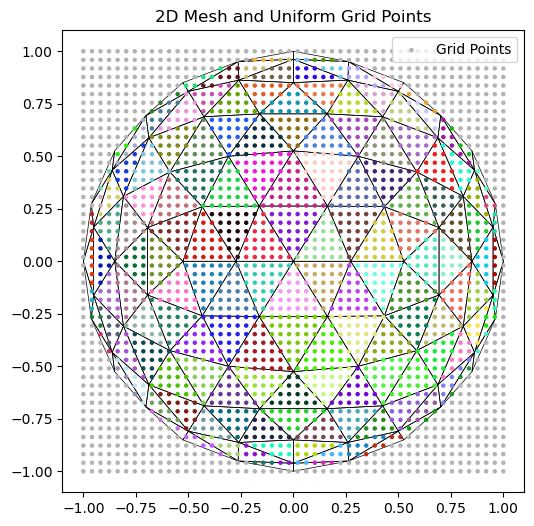

In [75]:
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np

# Create a uniform grid over the body1 cast_vertices

# Get the 2D projected vertices
verts2d = body1.cast_vertices  # shape (n_vertices, 2)

# Find the bounding box of the projected vertices
x_min, y_min = verts2d.min(axis=0)
x_max, y_max = verts2d.max(axis=0)

# Define the number of grid points along each axis
n_grid = 50  # You can adjust this for finer/coarser grid

# Create a uniform grid within the bounding box
x_grid = np.linspace(x_min, x_max, n_grid)
y_grid = np.linspace(y_min, y_max, n_grid)
xx, yy = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=-1)  # shape (n_grid*n_grid, 2)

# Instead of using matplotlib.tri.Triangulation (which fails for non-Delaunay/invalid meshes),
# manually check for each grid point which triangle (face) it falls into using barycentric coordinates.

faces = body1.faces[body1.mus > 0].astype(int)  # shape (n_faces, 3)
triangle_to_gridpts = {}

import jax
import jax.numpy as jnp

@jax.jit
def point_in_triangle(pt, tri):
    # pt: (2,), tri: (3,2)
    a = tri[0]
    b = tri[1]
    c = tri[2]
    v0 = b - a
    v1 = c - a
    v2 = pt - a
    den = v0[0]*v1[1] - v1[0]*v0[1]
    # Use jnp.where to avoid Python control flow
    is_degenerate = jnp.abs(den) < 1e-14
    u = (v2[0]*v1[1] - v1[0]*v2[1]) / den
    v = (v0[0]*v2[1] - v2[0]*v0[1]) / den
    inside = (u >= 0) & (v >= 0) & (u + v <= 1)
    return jnp.where(is_degenerate, False, inside)

# For each triangle, find which grid points are inside
for tri_idx, face in enumerate(faces):
    tri_verts = verts2d[face]  # (3,2)
    # Use jax.vmap to vectorize over grid_points
    inside_mask = jax.vmap(lambda pt: point_in_triangle(pt, tri_verts))(grid_points)
    inside = np.where(np.array(inside_mask))[0].tolist()
    if inside:
        triangle_to_gridpts[tri_idx] = inside

# Optionally, for each grid point, get the triangle index it falls into (-1 if outside)
grid_tri_indices = np.full(len(grid_points), -1, dtype=int)
for tri_idx, indices in triangle_to_gridpts.items():
    for i in indices:
        grid_tri_indices[i] = tri_idx

# grid_points now contains the uniform grid over the body1 cast_vertices
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the 2D mesh (projected vertices and faces)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5)
ax.add_collection(mesh)

# Plot the grid points, colored by which triangle they are in
import matplotlib.cm as cm

# Assign a color to each triangle index (use a colormap)
num_tris = len(faces)
# For points outside any triangle, assign a special color (e.g., gray)
# Use a more diverse colormap for better color separation
# Use a colormap with num_tris distinct colors, assigning a unique color to each triangle
cmap = cm.get_cmap('nipy_spectral', num_tris)

# Assign colors per point: each triangle gets a different color
colors = np.empty((len(grid_points), 4))
outside_color = np.array([0.7, 0.7, 0.7, 0.5])
inside_mask = grid_tri_indices != -1

# For each triangle, assign a completely random color
rng = np.random.default_rng(42)
random_colors = rng.random((num_tris, 4))
random_colors[:, 3] = 1.0  # set alpha to 1 for all

colors = np.empty((len(grid_points), 4))
outside_color = np.array([0.7, 0.7, 0.7, 0.5])
inside_mask = grid_tri_indices != -1

# Assign random color to each triangle's points
if np.any(inside_mask):
    colors[inside_mask] = random_colors[grid_tri_indices[inside_mask]]
colors[~inside_mask] = outside_color

sc = ax.scatter(
    grid_points[:, 0], grid_points[:, 1],
    s=5, c=colors, alpha=1., label='Grid Points'
)

ax.set_aspect('equal')
ax.set_title('2D Mesh and Uniform Grid Points')
ax.legend()
plt.show()


Number of triangles with at least one grid point in the circle: 0


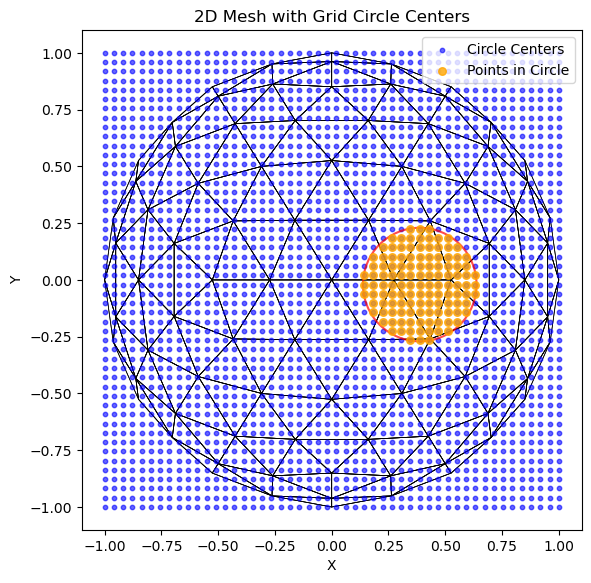

In [76]:
# Find the grid point (center) that touches the largest number of triangles
circle_radius = 0.25
circle_centers = grid_points  # shape (n_grid_points, 2)
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(6, 6))

# Plot the 2D mesh
verts2d = body1.cast_vertices  # shape (n_vertices, 2)
faces = body1.faces.astype(int)  # shape (n_faces, 3)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5, zorder=1)
ax.add_collection(mesh)

# Plot the grid points (circle centers)
ax.scatter(circle_centers[:, 0], circle_centers[:, 1], s=10, color='blue', alpha=0.6, label='Circle Centers', zorder=2)

# For each circle center, find the indices of grid_points within the circle and store in a dict
points_in_circles = {}
for i, center in enumerate(circle_centers):
    # Compute squared distances from this center to all grid points
    dists2 = np.sum((grid_points - center) ** 2, axis=1)
    # Find points within the circle (distance <= radius)
    inside_idx = np.where(dists2 <= circle_radius ** 2)[0]
    points_in_circles[i] = inside_idx

circle_idx = 1234
# Draw a circle at every center to show the radius
for i, center in enumerate(circle_centers):
    if i == circle_idx:
        # Only add label to the first circle for the legend
        label = 'Sample Circle' if i == 0 else None
        circle_patch = Circle(center, circle_radius, edgecolor='red', facecolor='none', lw=1.5, alpha=0.7, zorder=3, label=label)
        ax.add_patch(circle_patch)
# Color the points inside the first circle (as an example)
first_circle_idx = circle_idx
inside_idx = points_in_circles[first_circle_idx]
ax.scatter(
    grid_points[inside_idx, 0], grid_points[inside_idx, 1],
    s=30, color='orange', alpha=0.8, label='Points in Circle', zorder=4
)

# Count how many triangles have at least one vertex (from triangle_to_gridpts) that is also within the selected circle
# triangle_to_gridpts: dict mapping triangle index to grid point indices
# inside_idx: indices of grid points inside the selected circle

# Convert inside_idx to a set for fast lookup
inside_set = set(inside_idx)

# Count triangles with at least one grid point in the circle
triangles_with_common_points = [
    tri_idx for tri_idx, gridpt_indices in triangle_to_gridpts.items()
    if len(inside_set.intersection(gridpt_indices)) > 0
]
num_triangles_with_common_points = len(triangles_with_common_points)

print(f"Number of triangles with at least one grid point in the circle: {num_triangles_with_common_points}")


ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('2D Mesh with Grid Circle Centers')
ax.legend()
plt.tight_layout()
plt.show()


In [77]:
# For each circle, count how many triangles have at least one vertex inside that circle
triangles_hit_by_circle = []
for i, inside_idx in points_in_circles.items():
    inside_set = set(inside_idx)
    triangles_with_common_points = [
        tri_idx for tri_idx, gridpt_indices in triangle_to_gridpts.items()
        if len(inside_set.intersection(gridpt_indices)) > 0
    ]
    triangles_hit_by_circle.append(len(triangles_with_common_points))

triangle_counts = np.array(triangles_hit_by_circle)


In [78]:
triangle_counts

array([0, 0, 0, ..., 0, 0, 0])

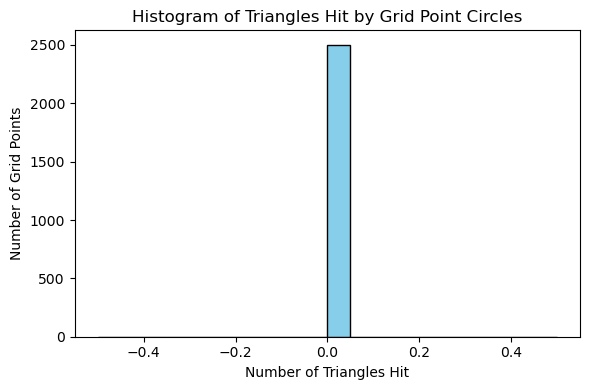

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(triangle_counts, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Triangles Hit')
plt.ylabel('Number of Grid Points')
plt.title('Histogram of Triangles Hit by Grid Point Circles')
plt.tight_layout()
plt.show()


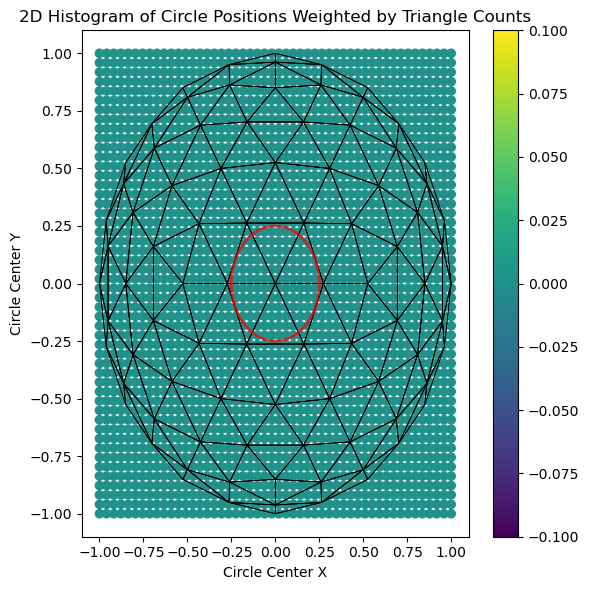

In [80]:
import matplotlib.pyplot as plt
x = circle_centers[:, 0]
y = circle_centers[:, 1]

# Use triangle_counts as the weights for each circle
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(x, y, c=triangle_counts, cmap='viridis')
ax.set_xlabel('Circle Center X')
ax.set_ylabel('Circle Center Y')
ax.set_title('2D Histogram of Circle Positions Weighted by Triangle Counts')


verts2d = body1.cast_vertices  # shape (n_vertices, 2)
faces = body1.faces.astype(int)  # shape (n_faces, 3)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5, zorder=2)
ax.add_collection(mesh)

center = np.array([0.0, 0.0])
circle = plt.Circle(center, circle_radius, color='red', fill=False, linewidth=2, alpha=0.7, zorder=3)
ax.add_patch(circle)


plt.colorbar(sc)
plt.tight_layout()
plt.show()


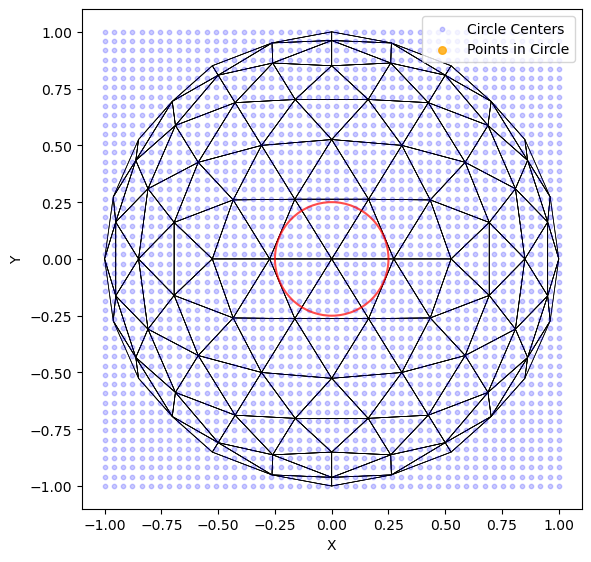

In [81]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(6, 6))

# Plot mesh (static)
verts2d = body1.cast_vertices
faces = body1.faces.astype(int)
polys = [verts2d[face] for face in faces]
mesh = PolyCollection(polys, edgecolor='k', facecolor='none', linewidth=0.5, zorder=1)
ax.add_collection(mesh)

# Plot all grid points (static, faded)
ax.scatter(circle_centers[:, 0], circle_centers[:, 1], s=10, color='blue', alpha=0.2, label='Circle Centers', zorder=2)

# Initialize highlight_scatter with shape (0, 2) to avoid IndexError
import numpy as np
highlight_scatter = ax.scatter([], [], s=30, color='orange', alpha=0.8, label='Points in Circle', zorder=4)
circle_patch = Circle((0, 0), circle_radius, edgecolor='red', facecolor='none', lw=1.5, alpha=0.7, zorder=3)
ax.add_patch(circle_patch)

ax.set_aspect('equal')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='upper right')
plt.tight_layout()

def init():
    # Set offsets to empty array with shape (0, 2) to avoid IndexError
    highlight_scatter.set_offsets(np.empty((0, 2)))
    circle_patch.center = (0, 0)
    return highlight_scatter, circle_patch

def animate(i):
    center = circle_centers[i]
    inside_idx = points_in_circles[i]
    # Ensure grid_points[inside_idx] is at least shape (0, 2)
    highlight_scatter.set_offsets(grid_points[inside_idx] if len(inside_idx) > 0 else np.empty((0, 2)))
    circle_patch.center = center
    return highlight_scatter, circle_patch

ani = FuncAnimation(
    fig, animate, frames=len(circle_centers), init_func=init,
    interval=1, blit=True, repeat=True
)
plt.show()


In [82]:
ani.save('largest_patch.gif')

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '1000.0', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'largest_patch.gif']' returned non-zero exit status 255.